In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp
import control as ctl
from time import time, sleep

# IMPORTANDO DADOS

In [31]:
df = pd.read_csv('DataBase.csv')
df.head()

,time,analog
0,110.062839,4034.0
1,110.141765,4045.0
2,110.221532,4059.0
3,110.301835,4044.0
4,110.382143,4043.0


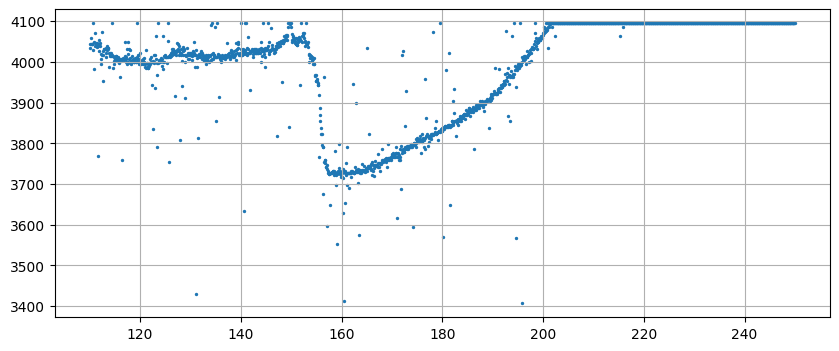

In [32]:
plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.analog, s=2)
plt.grid()

# NORMALIZANDO DADOS

In [33]:
T = 0.030

In [34]:
def normalizeData(df, timeKey, responseKey, T=0.15):
    initTime  = df[timeKey].iloc[0]
    finalTime = df[timeKey].iloc[-1] + T
    timeData  = np.arange(initTime, finalTime, T)
    
    lastValue = df[responseKey].iloc[0]
    desired = []

    for t in timeData:
        filtered = df.loc[df[timeKey] <= t][responseKey]
        
        if not filtered.empty:
            lastValue = filtered.iloc[-1]
        
        desired.append(lastValue)
    
    return timeData, desired


def normalizeTable(df, key, T=0.15):
    table = {key: []}

    for column in df.columns:
        if column == key:
            continue

        xData, yData = normalizeData(df, key, column, T)
        table[column] = yData

    table[key] = xData
    return pd.DataFrame(table) 


df['time'] = df.time - df.time[0]
df = normalizeTable(df, 'time', T)
df

,time,analog
0,0.00,4034.0
1,0.03,4034.0
2,0.06,4034.0
3,0.09,4045.0
4,0.12,4045.0
...,...,...
4659,139.77,4095.0
4660,139.80,4095.0
4661,139.83,4095.0
4662,139.86,4095.0


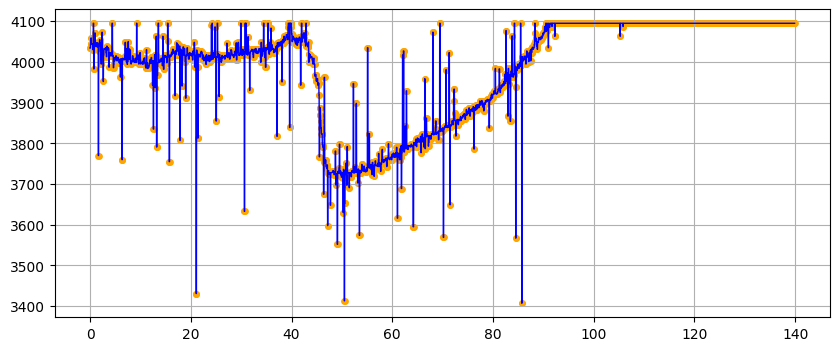

In [35]:
xData, yData = df.time.values, df.analog.values

plt.figure(figsize=(10, 4))
plt.scatter(xData, yData, s=15, color='orange')
plt.plot(xData, yData, linewidth=1, color='blue')
plt.grid()

# FILTRO PERFEITO
**DOMÍNIO DA FREQUÊNCIA** $\Rightarrow$ Fazendo a transformada de Fourier para obter os dados no domínio da frequência, onde o eixo horizontal indica a frequência e o eixo vertical indica a amplitude, geralmente as amplitudes maiores são os alvos desejados, perto de frequências baixas

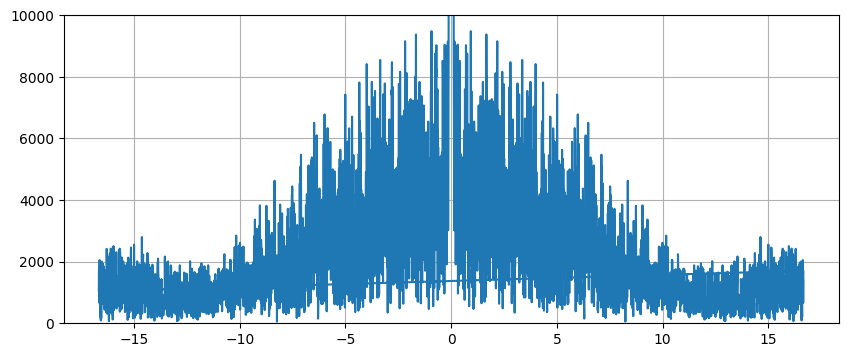

In [36]:
magnitude = np.fft.fft(yData)
frequency = np.fft.fftfreq(len(yData), T)

plt.figure(figsize=(10, 4))
plt.plot(frequency, np.abs(magnitude))
plt.ylim(0, 10000)
plt.grid()

**FILTRO PASSA BAIXA** $\Rightarrow$ O gráfico acima apresenta enorme ruído depois da frequência principal do sistema, o objetivo é eliminar o ruído e impedir com que essas frequências sejam interpretadas

- Isso é feito escolhendo uma frequência de corte, em que tudo que está acima dessa frequência é bloqueada

In [37]:
f_c = 0.1

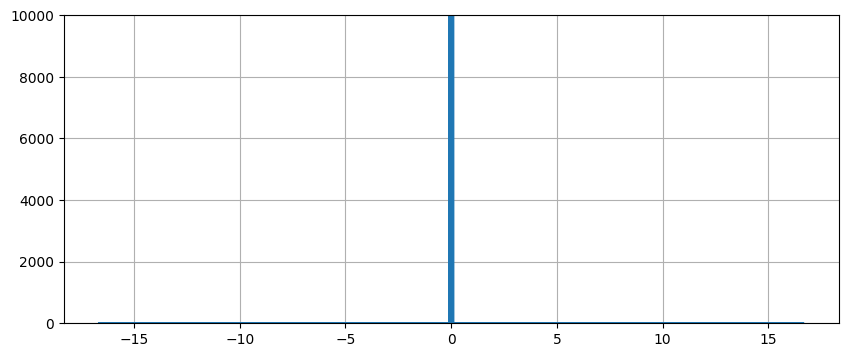

In [38]:
def applyLowBand(frequencyArray, magnitudeArray, upperLimit):
    allowed = np.abs(frequencyArray) <= upperLimit
    magnitudeArray[~allowed] = 0
    return magnitudeArray

magnitude = applyLowBand(frequency, magnitude, f_c)
plt.figure(figsize=(10, 4))
plt.plot(frequency, magnitude.real)
plt.ylim(0, 10000)
plt.grid()

- Voltando para o domínio do tempo

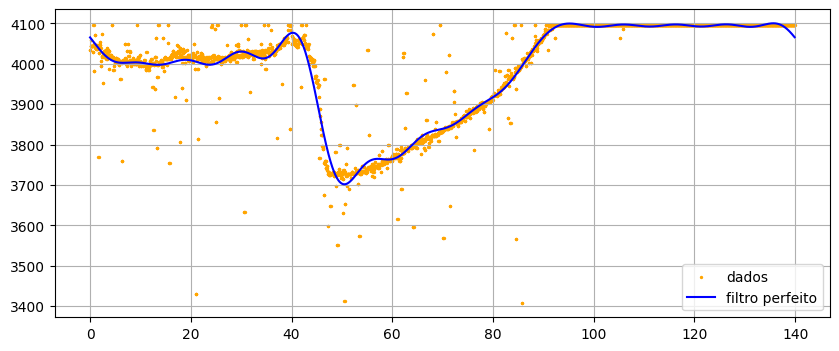

In [39]:
yData = np.fft.ifft(magnitude).real

plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.analog, s=2, color='orange', label='dados')
plt.plot(xData, yData, color='blue', label='filtro perfeito')
plt.legend(), plt.grid()
plt.show()